# Dataviz robots — Notebook de cours

Notebook prêt à exécuter pour le chapitre **Dataviz robots avec Python**.

Contenu:
- chargement + nettoyage
- KPI horaires
- visualisations de base (Matplotlib / Seaborn)
- détection d'erreurs avancée (heatmap, carte de contrôle, score d'anomalie, confusion matrix)

In [1]:
# chargement des dépendances

## 0) Imports et style

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (11, 6)

## 1) Chargement des données

Le notebook tente d'abord le chemin Docker/Jupyter, puis des chemins locaux relatifs.

In [3]:
candidates = [
    Path('/home/jovyan/work/data/robots_missions.csv'),
    Path('data/robots_missions.csv'),
    Path('../../data/robots_missions.csv'),
]

csv_path = next((p for p in candidates if p.exists()), None)
if csv_path is None:
    raise FileNotFoundError(f"Fichier introuvable. Chemins testés: {candidates}")

print(f"Chargement depuis: {csv_path}")
df = pd.read_csv(csv_path, parse_dates=['timestamp'])
print(df.shape)
df.head()

Chargement depuis: /home/jovyan/work/data/robots_missions.csv
(5409, 13)


,timestamp,robot_id,robot_type,zone,task_type,mission_duration_s,downtime_s,battery_pct,speed_mps,temperature_c,error_code,mission_status,incident_label
0,2026-02-02 08:00:00,R01,picker,C1,replenish,174,18,94.46,1.081,25.06,NaN,completed,0
1,2026-02-02 08:00:00,R09,forklift,A1,inventory_scan,179,19,93.04,1.197,22.87,NaN,completed,0
2,2026-02-02 08:10:00,R03,picker,C3,transport,219,13,90.91,1.257,25.00,NaN,completed,0
3,2026-02-02 08:10:00,R01,picker,D1,inventory_scan,242,27,98.40,1.537,25.04,NaN,completed,0
4,2026-02-02 08:20:00,R10,carrier,B2,pick,187,31,98.21,1.082,22.39,NaN,completed,0


## 2) Qualité des données et nettoyage

In [4]:
print('Lignes initiales:', len(df))

# Types numériques attendus
num_cols = ['mission_duration_s', 'downtime_s', 'battery_pct', 'speed_mps', 'temperature_c']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Nettoyage
before = len(df)
df = df.drop_duplicates()
df = df.dropna(subset=['timestamp', 'robot_id', 'zone', 'mission_duration_s', 'downtime_s', 'battery_pct'])
df = df[df['mission_duration_s'] > 0]
df = df[df['downtime_s'] >= 0]
df = df[df['battery_pct'].between(0, 100)]

after = len(df)
print('Lignes après nettoyage:', after)
print('Lignes supprimées:', before - after)

Lignes initiales: 5409
Lignes après nettoyage: 5406
Lignes supprimées: 3


## 3) Features analytiques

In [5]:
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.date
df['is_error'] = np.where(df['error_code'].fillna('') != '', 1, 0)
df['efficiency'] = df['mission_duration_s'] / (df['downtime_s'] + 1)

kpi_hour = df.groupby('hour', as_index=False).agg(
    missions=('robot_id', 'count'),
    error_rate=('is_error', 'mean'),
    avg_battery=('battery_pct', 'mean'),
)

kpi_hour.head()

,hour,missions,error_rate,avg_battery
0,0,203,0.024631,100.000000
1,1,203,0.034483,100.000000
2,2,213,0.032864,99.988216
3,3,206,0.038835,99.938641
4,4,223,0.031390,99.482691


## 4) Graphe 1 — Missions par heure (Matplotlib)

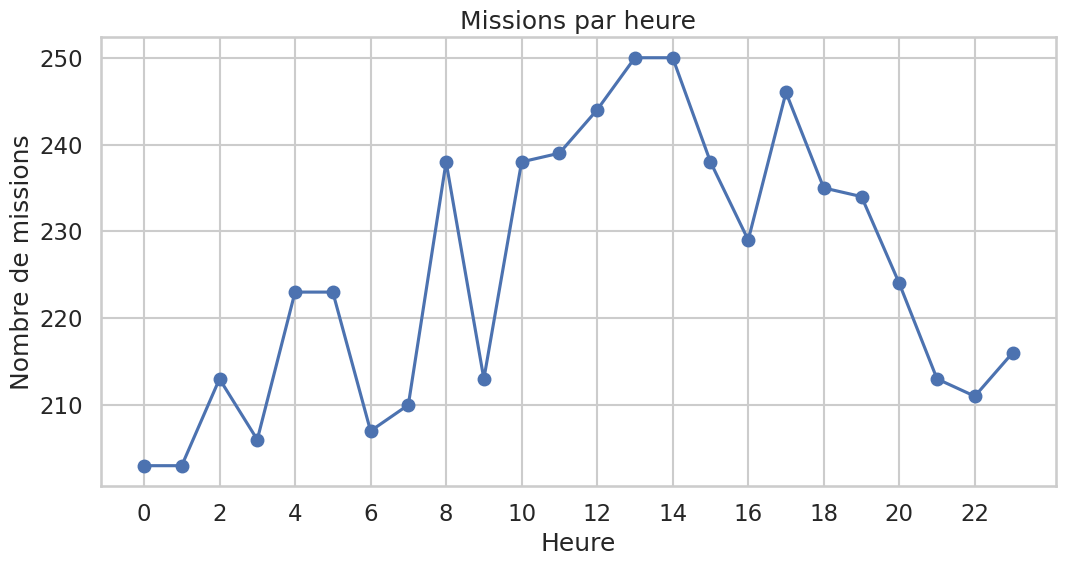

In [6]:
plt.figure(figsize=(11, 6))
plt.plot(kpi_hour['hour'], kpi_hour['missions'], marker='o')
plt.title('Missions par heure')
plt.xlabel('Heure')
plt.ylabel('Nombre de missions')
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()

## 5) Graphe 2 — Distribution batterie (Seaborn)

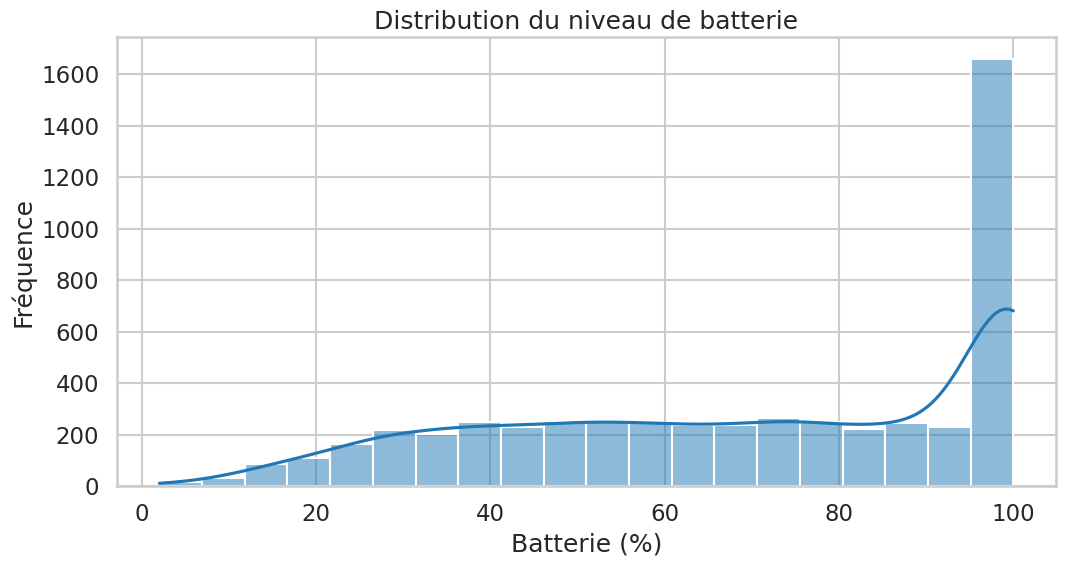

In [7]:
plt.figure(figsize=(11, 6))
sns.histplot(df, x='battery_pct', bins=20, kde=True, color='#1f77b4')
plt.title('Distribution du niveau de batterie')
plt.xlabel('Batterie (%)')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

## 6) Graphe 3 — Taux d'erreurs par zone

/tmp/ipykernel_21/904928084.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=zone_err, x='is_error', y='zone', palette='Reds_r')


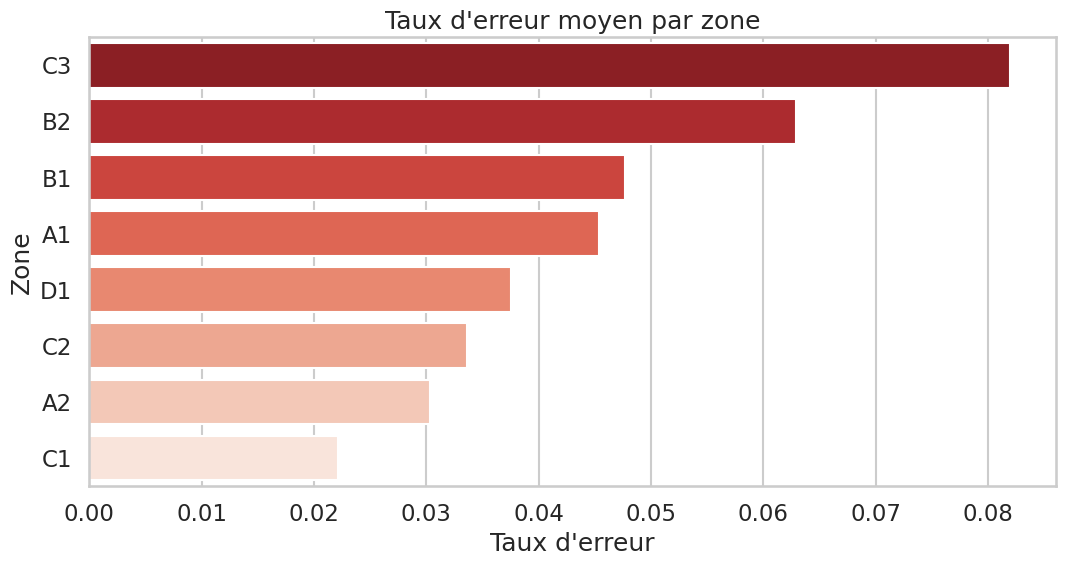

,zone,is_error
6,C3,0.081944
3,B2,0.062883
2,B1,0.047688
0,A1,0.045388
7,D1,0.037538
5,C2,0.033588
1,A2,0.030303
4,C1,0.022124


In [8]:
zone_err = (
    df.groupby('zone', as_index=False)['is_error']
      .mean()
      .sort_values('is_error', ascending=False)
)

plt.figure(figsize=(11, 6))
sns.barplot(data=zone_err, x='is_error', y='zone', palette='Reds_r')
plt.title("Taux d'erreur moyen par zone")
plt.xlabel("Taux d'erreur")
plt.ylabel('Zone')
plt.tight_layout()
plt.show()

zone_err

## 7) Graphe 4 — Matrice de corrélation capteurs

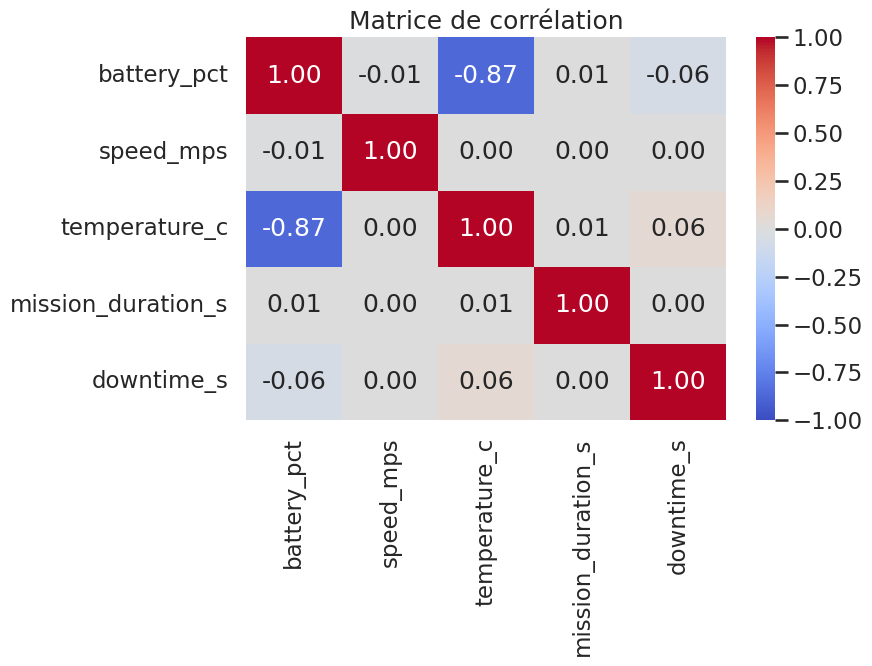

In [9]:
corr_cols = ['battery_pct', 'speed_mps', 'temperature_c', 'mission_duration_s', 'downtime_s']
corr = df[corr_cols].corr(numeric_only=True)

plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.show()

## 8) Approfondissement — Heatmap erreurs (zone x heure)

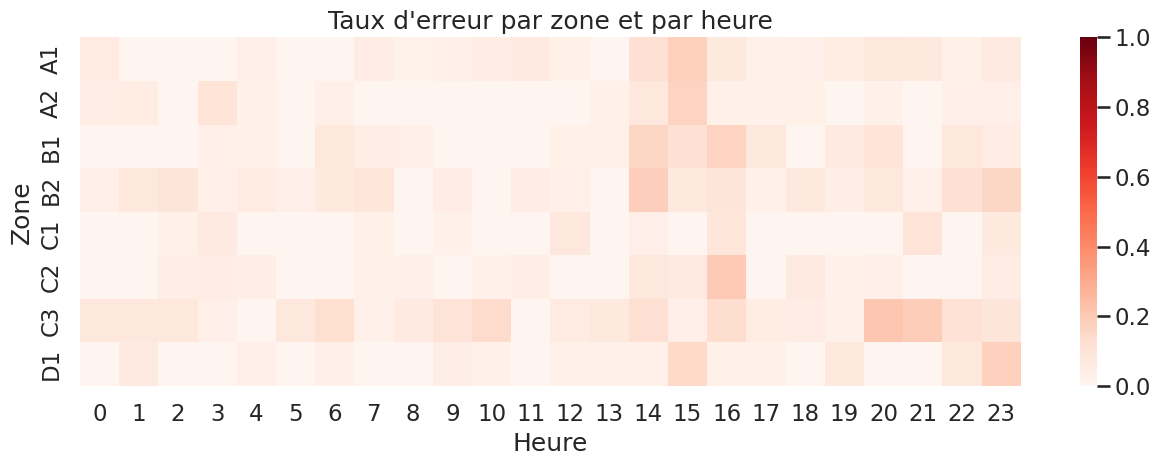

In [10]:
err_heat = (
    df.groupby(['zone', 'hour'], as_index=False)['is_error']
      .mean()
      .pivot(index='zone', columns='hour', values='is_error')
      .fillna(0)
)

plt.figure(figsize=(13, 5))
sns.heatmap(err_heat, cmap='Reds', vmin=0, vmax=1)
plt.title("Taux d'erreur par zone et par heure")
plt.xlabel('Heure')
plt.ylabel('Zone')
plt.tight_layout()
plt.show()

## 9) Approfondissement — Carte de contrôle (15 min)

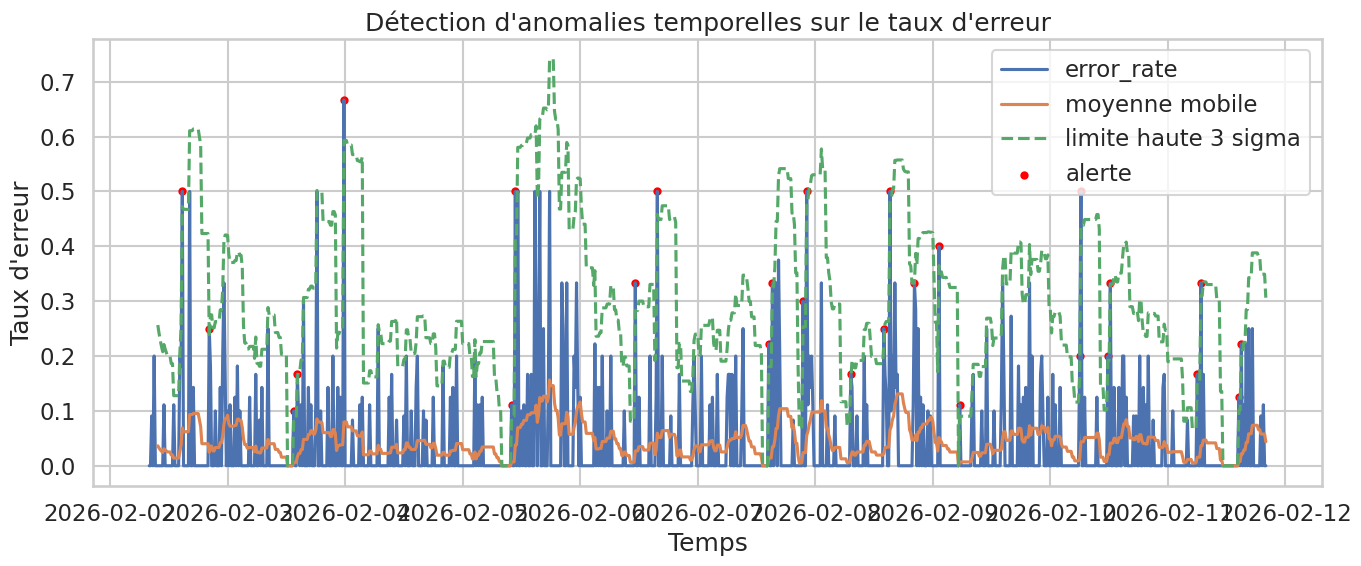

Nombre de créneaux en alerte: 27


In [11]:
ts = (
    df.set_index('timestamp')
      .resample('15min')['is_error']
      .mean()
      .rename('error_rate')
      .to_frame()
)

ts['mu_rolling'] = ts['error_rate'].rolling(16, min_periods=8).mean()
ts['sigma_rolling'] = ts['error_rate'].rolling(16, min_periods=8).std()
ts['upper'] = ts['mu_rolling'] + 3 * ts['sigma_rolling']
ts['pred_alert'] = (ts['error_rate'] > ts['upper']).astype(int)

plt.figure(figsize=(14, 6))
plt.plot(ts.index, ts['error_rate'], label='error_rate')
plt.plot(ts.index, ts['mu_rolling'], label='moyenne mobile')
plt.plot(ts.index, ts['upper'], '--', label='limite haute 3 sigma')
alert_mask = ts['pred_alert'] == 1
plt.scatter(ts.index[alert_mask], ts.loc[alert_mask, 'error_rate'], c='red', s=20, label='alerte')
plt.title("Détection d'anomalies temporelles sur le taux d'erreur")
plt.xlabel('Temps')
plt.ylabel("Taux d'erreur")
plt.legend()
plt.tight_layout()
plt.show()

print('Nombre de créneaux en alerte:', int(ts['pred_alert'].sum()))

## 10) Approfondissement — Score d'anomalie multivariable

In [12]:
feat = ['downtime_s', 'mission_duration_s', 'battery_pct', 'temperature_c']
z = (df[feat] - df[feat].mean()) / df[feat].std(ddof=0)
df['anomaly_score'] = np.sqrt((z ** 2).sum(axis=1))

threshold = df['anomaly_score'].quantile(0.99)
df['is_anomaly'] = (df['anomaly_score'] >= threshold).astype(int)

plt.figure(figsize=(11, 7))
sns.scatterplot(
    data=df,
    x='mission_duration_s',
    y='downtime_s',
    hue='is_anomaly',
    palette={0: '#1f77b4', 1: '#d62728'},
    alpha=0.6,
)
plt.title('Points anormaux selon score multivariable')
plt.xlabel('Durée mission (s)')
plt.ylabel('Downtime (s)')
plt.tight_layout()
plt.show()

print('Seuil score (P99):', round(float(threshold), 3))
print('Nombre d'anomalies:', int(df['is_anomaly'].sum()))

SyntaxError: unterminated string literal (detected at line 24) (1404127126.py, line 24)

## 11) Approfondissement — Baseline robot+heure et ratio d'écart

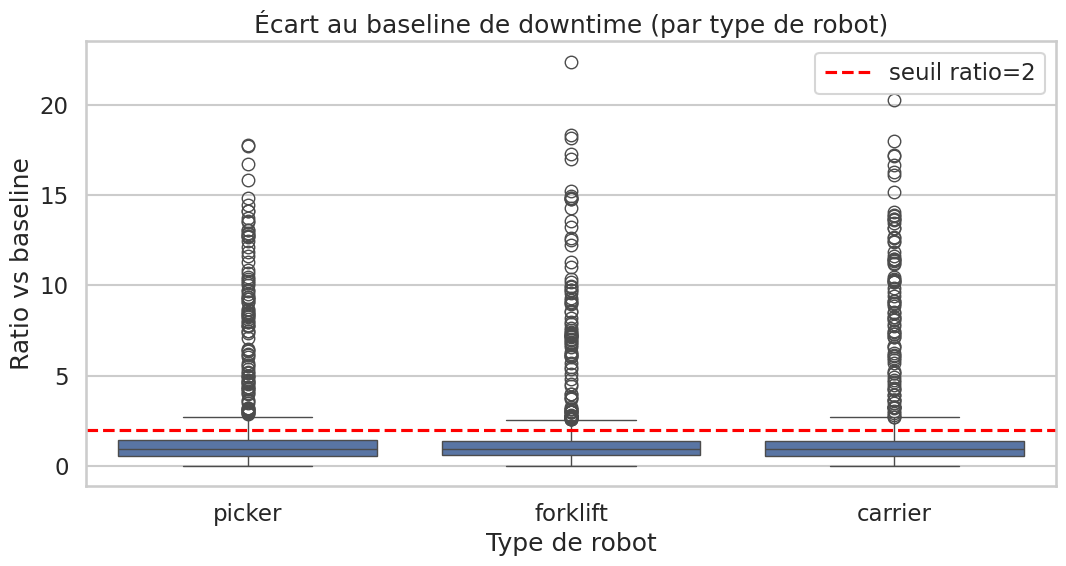

In [13]:
baseline = (
    df.groupby(['robot_id', 'hour'], as_index=False)['downtime_s']
      .median()
      .rename(columns={'downtime_s': 'downtime_baseline'})
)

df2 = df.merge(baseline, on=['robot_id', 'hour'], how='left')
df2['downtime_ratio'] = df2['downtime_s'] / (df2['downtime_baseline'] + 1)

plt.figure(figsize=(11, 6))
sns.boxplot(data=df2, x='robot_type', y='downtime_ratio')
plt.axhline(2.0, ls='--', c='red', label='seuil ratio=2')
plt.title("Écart au baseline de downtime (par type de robot)")
plt.xlabel('Type de robot')
plt.ylabel('Ratio vs baseline')
plt.legend()
plt.tight_layout()
plt.show()

## 12) Approfondissement — Matrice de confusion (si `incident_label`)

Ici, on compare un prédicteur simple `pred_alert` basé sur le score d'anomalie (P99).

In [14]:
if 'incident_label' in df.columns:
    eval_df = df[['incident_label', 'is_anomaly']].copy()
    eval_df['incident_label'] = pd.to_numeric(eval_df['incident_label'], errors='coerce').fillna(0).astype(int)
    eval_df['pred_alert'] = eval_df['is_anomaly'].astype(int)

    cm = pd.crosstab(eval_df['incident_label'], eval_df['pred_alert'])
    cm = cm.reindex(index=[0, 1], columns=[0, 1], fill_value=0)

    tn = cm.loc[0, 0]
    fp = cm.loc[0, 1]
    fn = cm.loc[1, 0]
    tp = cm.loc[1, 1]

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice de confusion de la détection')
    plt.xlabel('Alerte prédite')
    plt.ylabel('Incident réel')
    plt.tight_layout()
    plt.show()

    print(f'Precision: {precision:.3f}')
    print(f'Recall:    {recall:.3f}')
else:
    print("Colonne 'incident_label' absente: cellule ignorée.")

KeyError: "['is_anomaly'] not in index"

## 13) Export des KPI (optionnel)

In [15]:
out_dir = Path('outputs')
out_dir.mkdir(exist_ok=True)

kpi_hour.to_csv(out_dir / 'kpi_hour.csv', index=False)
zone_err.to_csv(out_dir / 'kpi_zone_error_rate.csv', index=False)

print('Exports écrits dans:', out_dir.resolve())

Exports écrits dans: /home/jovyan/work/starter-db/notebooks/outputs


## 14) Questions TP proposées

1. Ajuster le seuil d'anomalie (P99 -> P97/P95) et comparer `precision/recall`.
2. Créer un `lineplot` du `downtime_s` médian par heure et par `robot_type`.
3. Proposer 2 actions terrain basées sur les zones/heures à risque.